# 1. Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import r2_score as r2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams.update({'font.size': 14})
# %config InlineBackend.figure_format = 'svg'
%matplotlib inline

from datetime import datetime

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

In [2]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(16,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

# 2. Загрузка данных

### Описание датасета:
* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

### Пути к директориям и файлам

In [3]:
TRAIN_DATASET_PATH = './datasets/train.csv'
TEST_DATASET_PATH = './datasets/test.csv'

### Загрузка данных

In [4]:
train = pd.read_csv(TRAIN_DATASET_PATH)
train.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [5]:
test = pd.read_csv(TEST_DATASET_PATH)
test.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [6]:
train.shape[1] - 1 == test.shape[1]

True

### Приведение типов

In [7]:
train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

#### Указываем строковый тип данных для Id и DitrictId

In [8]:
train['Id'] = train['Id'].astype(str)
train['DistrictId'] = train['DistrictId'].astype(str)

test['Id'] = test['Id'].astype(str)
test['DistrictId'] = test['DistrictId'].astype(str)

# 3. EDA и очистка данных

In [9]:
num_feat = list(train.select_dtypes(exclude='object').columns)
obj_feat = list(train.select_dtypes(include='object').columns)
target = 'Price'
num_feat.remove(target)

## 3.1. Распределение целевой переменной

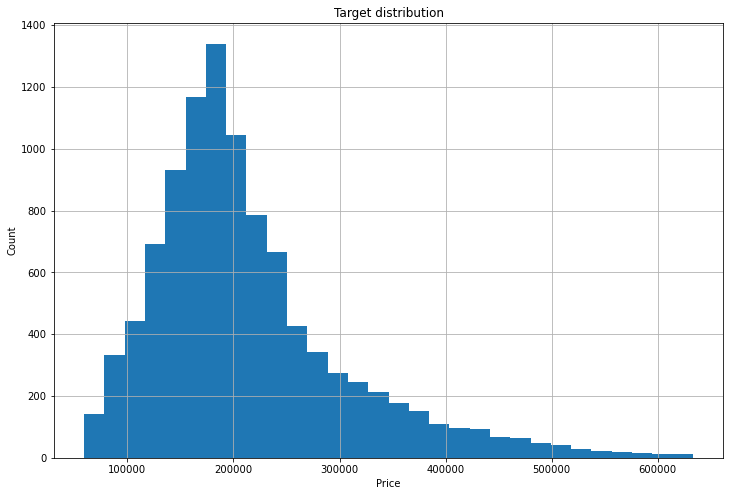

In [10]:
plt.figure(figsize = (12, 8))

train[target].hist(bins=30)
plt.ylabel('Count')
plt.xlabel(target)

plt.title('Target distribution')
plt.show()

## 3.2. Анализ признаков

### Количественные признаки

In [11]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
LifeSquare,7887.0,37.199645,86.241209,0.370619,22.769832,32.781260,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01
Social_1,10000.0,24.687000,17.532614,0.000000,6.000000,25.000000,36.000000,7.400000e+01
Social_2,10000.0,5352.157400,4006.799803,168.000000,1564.000000,5285.000000,7227.000000,1.908300e+04


#### Аномальные значения:

* Количество комнат не может быть 0 (min Rooms = 0)
* Ненормальное значение года (max HouseYear = 2005201...)
* 0 этажей в доме (min HouseFloor = 0)
* Максимальная жилая площадь > максимальной общей площади (max Square > max Life Square)
* Слишком большая максимальная площадь
* Есть пропущеные значения LifeSquare и Healthcare_1

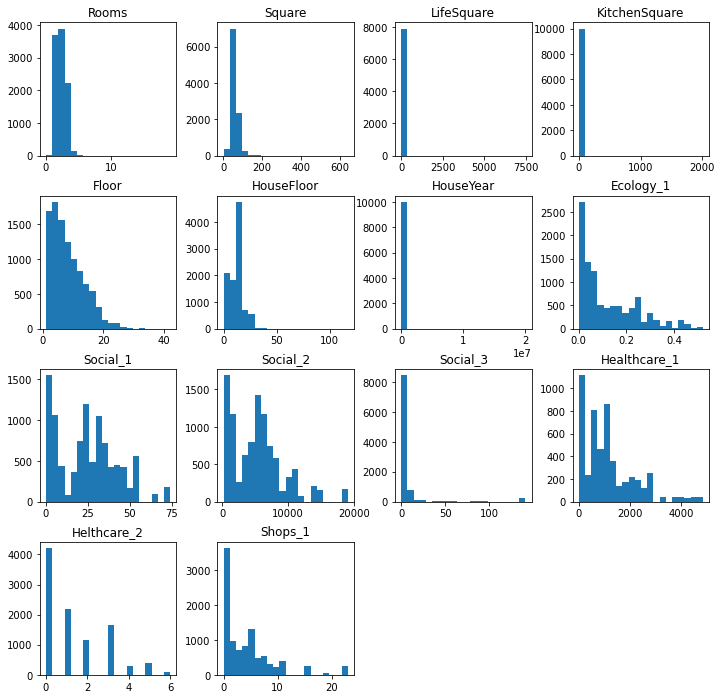

In [12]:
train[num_feat].hist(figsize=(12,12), bins=20, grid=False);

По графикам заметны аномальные значения в Rooms, Square, LifeSquare, KitchenSquare, HouseFloor, HouseYear и Social_3

#### Rooms

In [13]:
train['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

#### HouseYear

In [14]:
train['HouseYear'].sort_values().tail()

8296        2020
2350        2020
7246        2020
8828        4968
9163    20052011
Name: HouseYear, dtype: int64

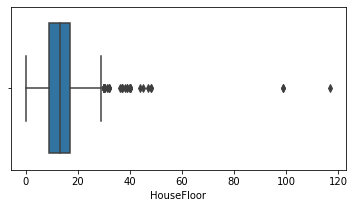

In [15]:
plt.figure(figsize=(6, 3))
sns.boxplot(train['HouseFloor'], whis=1.5)
plt.xlabel('HouseFloor')
plt.show()

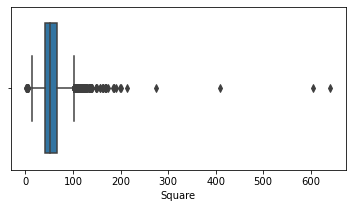

In [16]:
plt.figure(figsize=(6, 3))
sns.boxplot(train['Square'], whis=1.5)
plt.xlabel('Square')
plt.show()

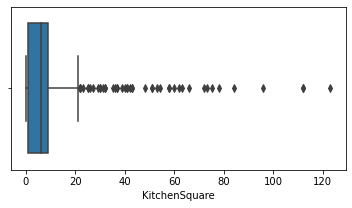

In [17]:
plt.figure(figsize=(6, 3))
sns.boxplot(train.loc[train['KitchenSquare'] < 500, 'KitchenSquare'], whis=1.5)
plt.xlabel('KitchenSquare')
plt.show()

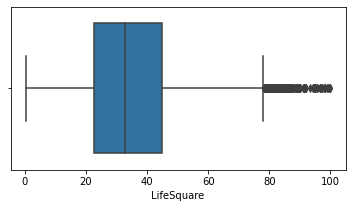

In [18]:
plt.figure(figsize=(6, 3))
sns.boxplot(train.loc[train['LifeSquare'] < 100, 'LifeSquare'], whis=1.5)
plt.xlabel('LifeSquare')
plt.show()

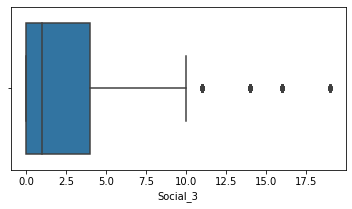

In [19]:
plt.figure(figsize=(6, 3))
sns.boxplot(train.loc[train['Social_3'] < 20, 'Social_3'], whis=1.5)
plt.xlabel('Social_3')
plt.show()

### Категориальные признаки

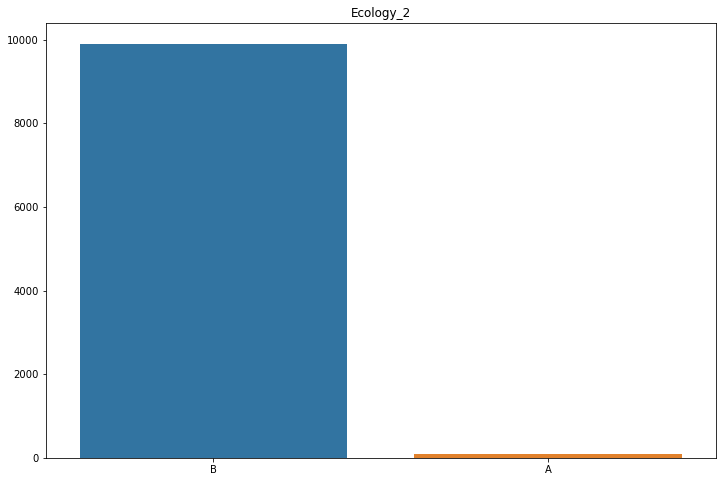

In [20]:
counts = train['Ecology_2'].value_counts()
plt.figure(figsize=(12,8))    
plt.title('Ecology_2')
sns.barplot(counts.index, counts.values)
plt.show()

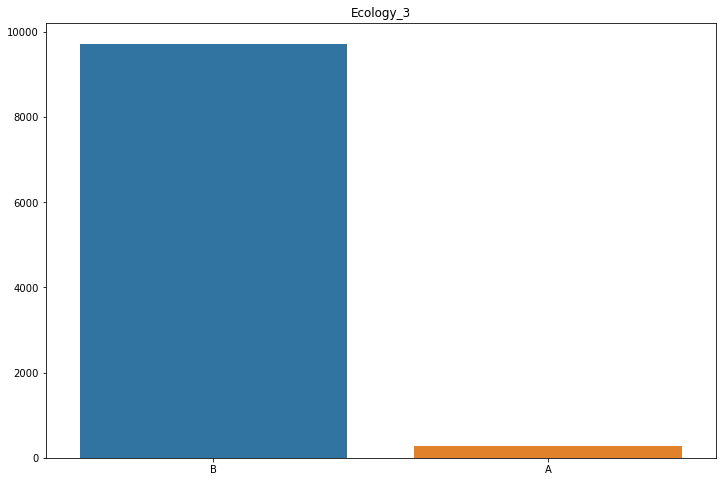

In [21]:
counts = train['Ecology_3'].value_counts()
plt.figure(figsize=(12,8))    
plt.title('Ecology_3')
sns.barplot(counts.index, counts.values)
plt.show()


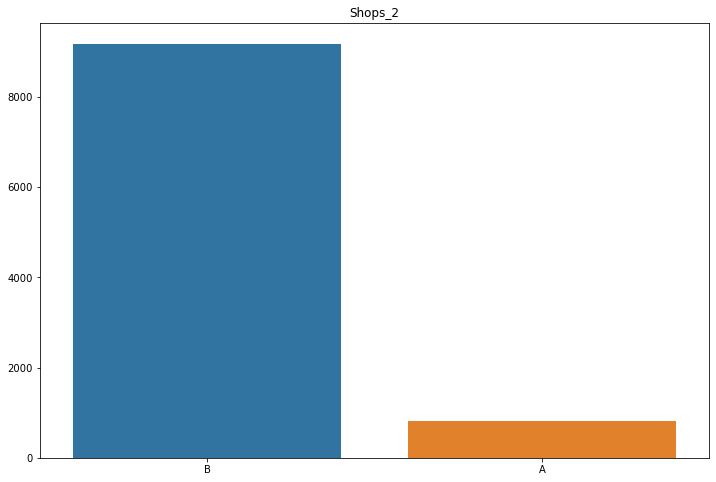

In [22]:
counts = train['Shops_2'].value_counts()
plt.figure(figsize=(12,8))    
plt.title('Shops_2')
sns.barplot(counts.index, counts.values)
plt.show()

### Матрица корреляций

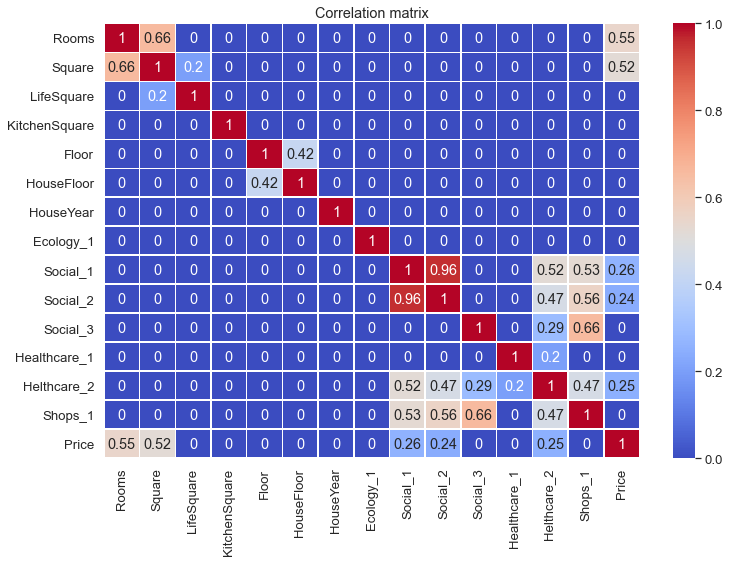

In [23]:
plt.figure(figsize = (12,8))

sns.set(font_scale=1.2)

corr_matrix = train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Social_1 и Social_2 слишком сильно коррелируют между собой

## 3.3. Анализ зависимости таргета от фичей

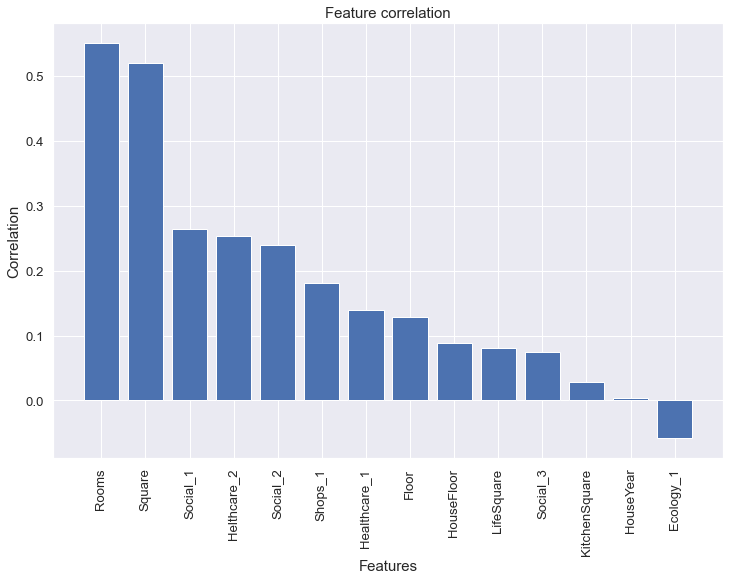

In [24]:
correlation = train.corrwith(train[target]).sort_values(ascending=False)
correlation.drop(target, inplace=True)

plt.figure(figsize = (12, 8))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature correlation', fontsize=15)
plt.show()

# 4: Очистка данных и Feature engineering

### Создание класса подготовки данных

In [25]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        
        # Rooms
        self.min_rooms = 1
        self.max_rooms = 5
        
        # HouseYear
        self.min_year = 1900
        self.max_year = datetime.now().year
        
        # HouseFloor
        self.min_floor = 1
        self.max_floor = 30
        
        # Square
        self.min_square = 20
        self.max_square = 110
        
        # KitchenSquare
        # В однокомнатных квартирах допускается проектировать кухни или кухни-ниши площадью не менее 5 м². (Google)
        self.min_kitchen_square = 5
        self.max_kitchen_square = 22
        
        # LifeSquare
        # Минимальная площадь общей жилой комнаты в однокомнатной квартире — 14 м². (Google)
        self.min_life_square = 14
        self.max_life_square = 78
        
        # MedPriceBySoc
        self.k_num_of_soc = 20
        
    def fit(self, df):
        """Сохранение статистик"""
        
        # Square
        self.median_square = df['Square'].median()
        
        # LifeSquare
        other_square = (self.median_square -\
                df['LifeSquare'].median() -\
                df['KitchenSquare'].median())
        self.k_life_square = other_square / df['Square'].median()
        
        # Social_3
        self.median_social_3 = df['Social_3'].median()
        
        # MedPriceByDistrict
        self.price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False)\
        .agg({'Price':'median'}).rename(columns={'Price':'MedPriceByDistrict'})
        self.price_by_district_median = self.price_by_district['MedPriceByDistrict'].median()

        
    def transform(self, df):
        """Трансформация данных"""
        
        # Rooms
        df.loc[df['Rooms'] < self.min_rooms, 'Rooms'] = self.min_rooms
        df.loc[df['Rooms'] > self.max_rooms, 'Rooms'] = self.max_rooms
        
        # HouseYear
        df.loc[df['HouseYear'] < self.min_year, 'HouseYear'] = self.min_year
        df.loc[df['HouseYear'] > self.max_year, 'HouseYear'] = self.max_year
        
        # HouseFloor
        error = df['HouseFloor'] < self.min_floor
        df.loc[error, 'HouseFloor'] = df.loc[error, 'Floor']

        df.loc[df['HouseFloor'] > self.max_floor, 'HouseFloor'] = self.max_floor

        error = df['Floor'] > df['HouseFloor']
        df.loc[error, 'Floor'] = df.loc[error, 'HouseFloor']
        
        # Square
        df.loc[(df['Square'] < self.min_square) |\
               (df['Square'] > self.max_square), 'Square'] = self.median_square
        
        # KitchenSquare
        df.loc[df['KitchenSquare'] < self.min_kitchen_square, 'KitchenSquare'] = self.min_kitchen_square
        df.loc[df['KitchenSquare'] > self.max_kitchen_square, 'KitchenSquare'] = self.max_kitchen_square
        
        # LifeSquare
        # Заполнение пропусков
        error = df['LifeSquare'].isnull()
        df.loc[error, 'LifeSquare'] = df.loc[error, 'Square'] * self.k_life_square
        # 
        df.loc[df['LifeSquare'] < self.min_life_square, 'LifeSquare'] = self.min_life_square
        df.loc[df['LifeSquare'] > self.max_life_square, 'LifeSquare'] = self.max_life_square
        
        # Social_3
        df.loc[df['Social_3'] > 10, 'Social_3'] = self.median_social_3
        
        # Бинарные признаки
        df['Ecology'] = df['Ecology_2'].replace({'A':1, 'B':2})
        df['Ecology'] += df['Ecology_3'].replace({'A':10, 'B':20})
        
        df['Shops_b'] = df['Shops_2'].replace({'A':0, 'B':1})

        return df


    def features(self, df):
        """Построение новых признаков"""
        
        # MedPriceByDistrict
        df = df.merge(self.price_by_district, on=['DistrictId', 'Rooms'], how='left')
        df.fillna(self.price_by_district_median, inplace=True)

        # MeanRoomSquare
        df['MeanRoomSquare'] = df['Square'] / df['Rooms']
        
        # СonvenienceFactor
        df['СonvenienceFactor'] = df['Social_1']/df['Social_1'].max()
        df['СonvenienceFactor'] += df['Social_3']/df['Social_3'].max()
        df['СonvenienceFactor'] += df['Helthcare_2']/df['Helthcare_2'].max()
        df['СonvenienceFactor'] += df['Shops_1']/df['Shops_1'].max()
        df['СonvenienceFactor'] += df['MeanRoomSquare']/df['MeanRoomSquare'].max()
        
        # FloorInHouse
        df['FloorInHouse'] = df['HouseFloor']/df['Floor']
        
        return df


### Обработка данных

In [26]:
pipeline = DataPipeline()

# Тренировачные
pipeline.fit(train)
train = pipeline.transform(train)
train = pipeline.features(train)

# Валидационные
test = pipeline.transform(test)
test = pipeline.features(test)

### Список признаков, которые используются в модели
Не указываем:
* Social_2 - Social_1 и Social_2 слишком сильно коррелируют между собой + Social_2 меньше влияет на таргет
* Healthcare_1 - Слишком большое кол-во пропусков

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  10000 non-null  object 
 1   DistrictId          10000 non-null  object 
 2   Rooms               10000 non-null  float64
 3   Square              10000 non-null  float64
 4   LifeSquare          10000 non-null  float64
 5   KitchenSquare       10000 non-null  float64
 6   Floor               10000 non-null  float64
 7   HouseFloor          10000 non-null  float64
 8   HouseYear           10000 non-null  int64  
 9   Ecology_1           10000 non-null  float64
 10  Ecology_2           10000 non-null  object 
 11  Ecology_3           10000 non-null  object 
 12  Social_1            10000 non-null  int64  
 13  Social_2            10000 non-null  int64  
 14  Social_3            10000 non-null  int64  
 15  Healthcare_1        10000 non-null  float64
 16  Helth

In [28]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Helthcare_2', 
                 'Ecology_1', 'Social_1', 'Social_3', 'Shops_1', 'Shops_b', 'Ecology']
new_feature_names = ['MedPriceByDistrict', 'MeanRoomSquare', 'FloorInHouse', 'СonvenienceFactor']

target = 'Price'

# 5. Разбиение на train / test

In [29]:
X = train[feature_names + new_feature_names]
y = train[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=21)

# 6. Построение модели

In [30]:
%%time
model = RandomForestRegressor(
    max_depth = 15,
    n_estimators = 175,
    min_samples_leaf=15,
    random_state=21,
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

Wall time: 6.83 s


# 7. Оценка финальной модели

Train R2:	0.805
Test R2:	0.734


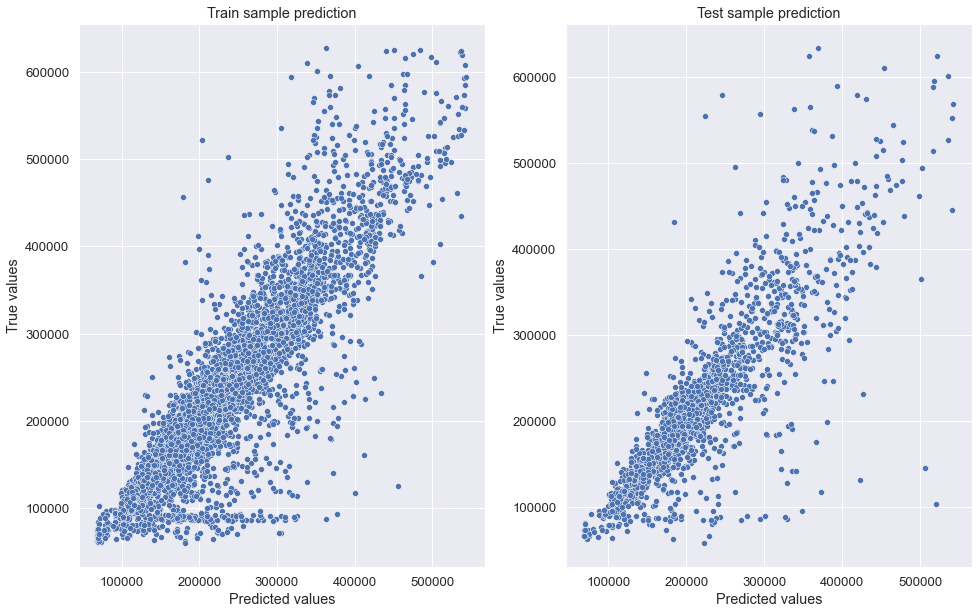

In [31]:
evaluate_preds(y_train, y_train_pred, y_test, y_test_pred)

In [32]:
cv_score = cross_val_score(model, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score.mean()

0.7315663363592778

In [33]:
feature_importances = pd.DataFrame(
    zip(X_train.columns, model.feature_importances_), 
    columns=['feature_name', 'importance']
)

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
14,MedPriceByDistrict,0.776957
1,Square,0.065721
15,MeanRoomSquare,0.047352
17,СonvenienceFactor,0.017196
3,KitchenSquare,0.013309
2,LifeSquare,0.012837
9,Social_1,0.012711
6,HouseYear,0.010747
10,Social_3,0.010088
5,HouseFloor,0.007493


# 8. Прогнозирование на тестовом датасете

In [34]:
submission = pd.DataFrame()
submission['Id'] = test['Id']
submission['Price'] = model.predict(test[feature_names+new_feature_names])
submission.head()

,Id,Price
0,4567,165763.690377
1,5925,122784.644279
2,960,142584.939796
3,3848,138418.822516
4,746,170549.074485


In [35]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      5000 non-null   object 
 1   Price   5000 non-null   float64
dtypes: float64(1), object(1)
memory usage: 117.2+ KB


In [36]:
submission.to_csv('submission.csv', index=False)